# LSTM for Part-of-Speech Tagging
Part of speech tagging is the process of determining the category of word in accordance with its syntactic functions. So basically deciding wheter a word is a *noun*, *verb* etc.<br>In this notebook I will create simple LSTM model which will be able to determine wheter a word is a *noun*, *verb* or *adjective* in a given sentence.<br>

#### Why do we even need that?
It can be used in various ways but the most popular and useful are:
- Determinig on what subject is someone talking about
- Creating artificial sentences
- Understanding the context of a sentence (example: We have **major** advantage VS **major** Ted, report for duty

# Preparing the Data
"The data" in that case will be 4 sentences I wrote, so very small dataset but for the sake of example it is perfect. Train set is a list of 4 tuples, where each tuple has a following structure: `(["word1", "word2", "word3", ...],["tag1", "tag2", "tag3", ...])` and tags are `DET, NN and V`

In [2]:
# import needed libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# create training data
training_data = [
    ("The princess drunk that juice".lower().split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Taylor admire the Kanye".lower().split(), ["NN", "V", "DET", "NN"]),
    ("The dog likes that rope".lower().split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Those cats eat garbage".lower().split(), ["DET", "NN", "V", "NN"])
]

# create dictionary of unique words
word2idx = {}
for words, tags in training_data:
    for word in words:
        if word not in word2idx:
            word2idx[word] = len(word2idx)
            
# create dictionary for tags also
tag2idx = {"DET" : 0, "NN" : 1, "V" : 2}

print(word2idx)
print(tag2idx)

{'the': 0, 'princess': 1, 'drunk': 2, 'that': 3, 'juice': 4, 'taylor': 5, 'admire': 6, 'kanye': 7, 'dog': 8, 'likes': 9, 'rope': 10, 'those': 11, 'cats': 12, 'eat': 13, 'garbage': 14}
{'DET': 0, 'NN': 1, 'V': 2}


Now let's define a helper function that converts list of words into torch tensor using previously defined `word2idx`

In [4]:
def prepare_sequence(sequence, dictionary):
    """
    
    Parameters:
    sequence - list of words that will be mapped to torch tensor
    dictionary - dict that maps words to indices
    
    """
    mappedwords = [dictionary[word] for word in sequence]
    return torch.LongTensor(mappedwords)

example = prepare_sequence(training_data[1][0], word2idx)
print(example)

tensor([5, 6, 0, 7])


# The model

Assumptions:
- Input is a sequence of words so ["word1", "word2", "word3", ...]
- All words are in the previously defined vocabulary: `word2idx`
- We have 3 Tags: Noun(NN), Verb(V) and Determiner(DET)
- The goal is to predict tag for each word

But there is a problem with input size. Number of words in the sentence can vary so to address that problem we have to use *word embeddings*. Each word in our vocabulary will be presented as an vector of size `n`. Moreover each entry in a vector can be treated as a feature of the word, so due to that words(embedded vectors) can be compared using an angle between them as a measure of similarity (more about that [here](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#word-embeddings-in-pytorch)).<br>

Structure of LSTM<br>
<img src="images/LSTM3.png"><br>
Credits: Udacity Computer vision Nanodegree



In [5]:
# Model for tagging parts of speech
class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        """
        Initialize layers of this model.
        
        Parameters:
        
        """
        super().__init__()
        # set dimension of hidden layer
        self.hidden_dim = hidden_dim
        
        # first layer - embedding: turns words into vector of size embedding_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # second layer - LSTM takes embedded word vectors as input and outputs hidden states of size hidded_dim
        # (in, out) = (embedding_dim, hidden_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        # third layer - linear layer that maps output of the LSTM to the number of tags we want
        # (in, out) = (hidden_dim, tagse_size)
        self.hidden2tags = nn.Linear(hidden_dim, tagset_size)
        
        # initialize the hidden state
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
        """
        Initialize hidden state of the model. At the begining of training we set this to 0's because we did not see anything before that.
        """
        # dimensions here are (n_layers, batch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim), torch.zeros(1, 1, self.hidden_dim))
    
    def forward(self, sentence):
        """
        Define the feedforward pass of the model
        """
        # create embedded vectors for each word in a sentence
        embedding = self.word_embeddings(sentence)
        
        # get the output an hidden state of the LSTMby applying it to embedded vectors
        lstm_out, self.hidden = self.lstm(embedding.view(len(sentence), 1, -1), self.hidden)
        
        # get the scores for the most likely tag for a word
        tag_outputs = self.hidden2tags(lstm_out.view(len(sentence),-1))
        tag_scores = F.log_softmax(tag_outputs, dim=1)
        
        return tag_scores        

# Training

In [6]:
# define embedding dimension, here we have a simple example so we will keep it small
# in more complex tasks those vectors grows to sizes like 64, 128 or even 256
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

# instantiate the model
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), len(tag2idx))

# define loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# And now little test before training
test_sentence = "The dog drunk that juice".lower().split()

# first we need to prepare input sequence
inputs = prepare_sequence(test_sentence,word2idx)

tag_scores = model(inputs)
# here we have torch tensor of size (5, 3) because fro each word we have 3 predictions regarding part of speech tag (DET, NN, V)
print(tag_scores, tag_scores.shape)

tensor([[-1.0880, -1.1530, -1.0572],
        [-1.1327, -1.1362, -1.0305],
        [-1.0290, -1.1485, -1.1223],
        [-1.0473, -1.1636, -1.0884],
        [-1.1103, -1.1488, -1.0398]], grad_fn=<LogSoftmaxBackward>) torch.Size([5, 3])


## Let's train the model
In epoch of the training loop each sentence will go through the LSTM model. For each sentence following actions will be taken:
- zero the gradients
- zero the hidden state of LSTM. WHY? because hidden state is for "remembering" words within the sentence in order to establish connections between them. Not zero-ing hidden state after each senetence would cause the end state from one sentence be an input to the first LSTM cell of the following sentence which would indicate connection between them which is not true in our case
- Prepares our data for training: turn sentences into tensors
- Runs a forward pass on our inputs to get tag_scores
- Calculates the loss between tag_scores and the true tag
- Updates the weights of our model using backpropagation

Epoch: 20, loss: 0.96986
Epoch: 40, loss: 0.79845
Epoch: 60, loss: 0.55432
Epoch: 80, loss: 0.31621
Epoch: 100, loss: 0.17086
Epoch: 120, loss: 0.10280
Epoch: 140, loss: 0.06949
Epoch: 160, loss: 0.05108
Epoch: 180, loss: 0.03978
Epoch: 200, loss: 0.03227
Epoch: 220, loss: 0.02699
Epoch: 240, loss: 0.02309
Epoch: 260, loss: 0.02012
Epoch: 280, loss: 0.01778
Epoch: 300, loss: 0.01590
Epoch: 320, loss: 0.01435
Epoch: 340, loss: 0.01307
Epoch: 360, loss: 0.01199
Epoch: 380, loss: 0.01106
Epoch: 400, loss: 0.01026
Epoch: 420, loss: 0.00956
Epoch: 440, loss: 0.00895
Epoch: 460, loss: 0.00841
Epoch: 480, loss: 0.00793
Epoch: 500, loss: 0.00750


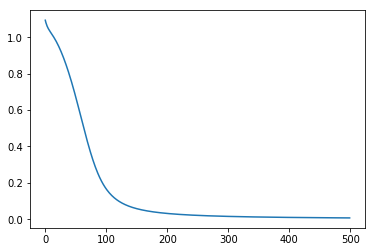

In [7]:
# In this exapmle we have only 4 sentences in outr train set so 300 epochs is not much 
n_epochs = 500
epoch_list = []

for epoch in range(n_epochs):
    
    epoch_loss = 0.0
    
    # get all sentences and corresponding tags in the training data
    for sentence, tags in training_data:
        
        # zero the gradients
        model.zero_grad()

        # zero the hidden state of the LSTM, this detaches it from its history
        model.hidden = model.init_hidden()

        # prepare the inputs for processing by out network, 
        # turn all sentences and targets into Tensors of numerical indices
        sentence_in = prepare_sequence(sentence, word2idx)
        targets = prepare_sequence(tags, tag2idx)

        # forward pass to get tag scores
        tag_scores = model(sentence_in)

        # compute the loss, and gradients 
        loss = loss_function(tag_scores, targets)
        epoch_loss += loss.item()
        loss.backward()
        
        # update the model parameters with optimizer.step()
        optimizer.step()
    
    # add loss fro meach epoch to the lsit for printing purposes
    epoch_list.append(epoch_loss/len(training_data))
    # print out avg loss per 20 epochs
    if(epoch%20 == 19):
        print("Epoch: %d, loss: %1.5f" % (epoch+1, epoch_loss/len(training_data)))

plt.plot(epoch_list)
plt.show()

I can be seen that loss quickly converges. Now we can check again our test sentence `The dog drunk that juice`

In [38]:
# test sentence again
test_sentence = "The dog drunk that juice".lower().split()

# covert sentence to the input format
test_input = prepare_sequence(test_sentence, word2idx)

# predicts tag scores
tag_scores = model(test_input)

# print the most likely tag for each word
_, predicted_tags = torch.max(tag_scores, dim=1)
# undo the tags mapping in order to display keys, not values
final_output = [list(tag2idx.keys())[tag_score]for tag_score in predicted_tags.tolist()]
print(test_sentence, final_output)

['the', 'dog', 'drunk', 'that', 'juice'] ['DET', 'NN', 'V', 'DET', 'NN']


Now, our model perfectly predicted part of speech for each word in the test sentence.